# 📚 Sinhala Mithuru Research Project
## Final Phase: Integrated Handwriting Inference System

### 🟢 SECTION 1: SYSTEM INTEGRATION & ASSET LOADING

**Description:**
This section consolidates the research assets developed in Module A and Module B. It loads the two specialized neural networks and their respective statistical scalers.

**Scientific Rationale:**
- **Model A (Character Recognition):** Identifies the character from 38 Sinhala classes.
- **Model B (Quality Assessment):** Evaluates the structural integrity of the stroke (Binary: Correct/Wrong).
- **Dual Scalers:** Since both models were trained on different datasets and potentially different feature distributions, using their unique scalers is mandatory to maintain accuracy.

In [2]:
# Installing all necessary dependencies for the Integrated System
!pip install -q tensorflow numpy matplotlib joblib scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import json
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# 1. Loading Research Assets
print("⏳ Loading Sinhala Mithuru Expert Models...")

try:
    # Model A: Character Recognition
    char_model = load_model('sinhala_mithuru_char_recognizer_v1.keras') #
    char_scaler = joblib.load('char_scaler_v1.pkl') #
    
    # Model B: Quality Assessment
    qual_model = load_model('quality_model_v1.keras') #
    qual_scaler = joblib.load('scaler_v1.pkl') #
    
    # Configuration Mapping
    with open('config.json', 'r', encoding='utf-8') as f:
        CHAR_CONFIG = json.load(f) #
        
    print("✅ All research assets loaded successfully.")
except Exception as e:
    print(f"❌ Error loading assets: {e}")

# Fixed class order as per training metadata
DYNAMIC_CLASSES = [
    'A', 'AEe', 'Aa', 'Ae', 'E', 'Ee', 'G', 'Gi', 'Gii', 'Gu', 'Guu', 
    'H', 'I', 'Ii', 'K', 'Ka', 'Ke', 'Kee', 'Ki', 'Kii', 'Kii ', 'Ku', 
    'N', 'O', 'Oo', 'Ou', 'P', 'Pu', 'Puu', 'R', 'S', 'T', 'Th', 'U', 
    'Uu', 'Y', 'g', 'k'
]

2026-01-04 01:35:10.122161: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 01:35:10.225240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


⏳ Loading Sinhala Mithuru Expert Models...


I0000 00:00:1767490518.117571     167 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:35:00.0, compute capability: 7.5


✅ All research assets loaded successfully.


### 🟢 SECTION 2: UNIFIED PREPROCESSING PIPELINE

**Description:**
A standard function to convert raw JSON stroke data into a format understandable by both models.

**Scientific Rationale:**
The consistency of the preprocessing pipeline (Interpolation and Feature Extraction) is the backbone of the system's reliability. Any deviation in how $x, y, dx, dy, p$ are calculated during inference will lead to incorrect predictions.

In [4]:
def preprocess_for_inference(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
        strokes = data['strokes']

    pts = []
    for s in strokes:
        for p_val in s:
            pts.append([p_val.get('x',0), p_val.get('y',0), 
                        p_val.get('dx',0), p_val.get('dy',0), 
                        p_val.get('p',0)])
            
    if len(pts) < 5: return None, None
    path = np.array(pts, dtype='float32')

    # Path distance based interpolation (150 points)
    dist = np.sqrt(np.sum(np.diff(path[:, :2], axis=0)**2, axis=1))
    cum_dist = np.insert(np.cumsum(dist), 0, 0)
    interp_d = np.linspace(0, cum_dist[-1], 150)
    
    nx = np.interp(interp_d, cum_dist, path[:, 0]) / 600 # Normalized to canvas size
    ny = np.interp(interp_d, cum_dist, path[:, 1]) / 600
    ndx = np.interp(interp_d, cum_dist, path[:, 2])
    ndy = np.interp(interp_d, cum_dist, path[:, 3])
    np_state = np.round(np.interp(interp_d, cum_dist, path[:, 4]))

    raw_processed = np.stack([nx, ny, ndx, ndy, np_state], axis=1)
    return raw_processed, strokes

### 🟢 SECTION 3: MASTER INFERENCE & QUALITATIVE REPORTING

**Description:**
The final algorithm that combines character classification, quality verification, and metadata validation (Strokes count).

**Research Rationale:**
By integrating multiple checks (Shape, Order, and Stroke count), the system provides a comprehensive "Learning Feedback" rather than a simple 'True/False' answer. This mimics a teacher's assessment style in a digital environment.

/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3462 (\N{SINHALA LETTER AAYANNA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Sinhala natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


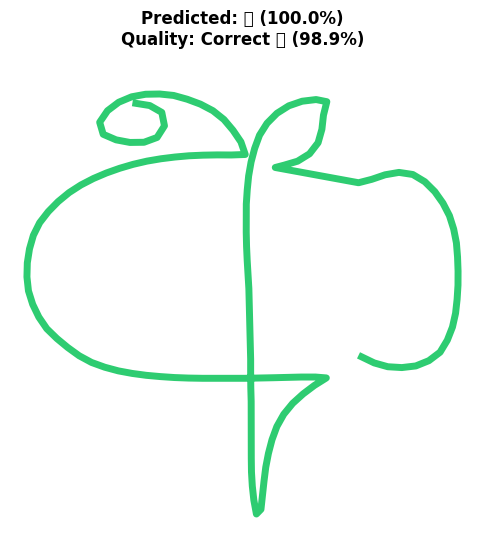

📄 පරීක්ෂණ වාර්තාව: Aa_1766998930493.json
🎯 හඳුනාගත් අකුර: ආ (Aa)
⚖️ ගුණාත්මකභාවය: Correct ✅ (98.9%)


In [10]:
def sinhala_mithuru_master_test(json_file):
    # 1. Preprocessing
    processed_data, raw_strokes = preprocess_for_inference(json_file)
    if processed_data is None: return

    # 2. Scaling for Model A
    input_char = char_scaler.transform(processed_data.reshape(-1, 5)).reshape(1, 150, 5)
    char_pred = char_model.predict(input_char, verbose=0)
    char_idx = np.argmax(char_pred)
    eng_label = DYNAMIC_CLASSES[char_idx] #
    
    # 3. Scaling for Model B
    input_qual = qual_scaler.transform(processed_data.reshape(-1, 5)).reshape(1, 150, 5)
    qual_score = qual_model.predict(input_qual, verbose=0)[0][0] #
    
    # 4. Metadata Extraction from config.json
    meta = CHAR_CONFIG.get(eng_label, {"symbol": eng_label, "strokes": 1})
    sinhala_char = meta['symbol']
    expected_strokes = meta['strokes']
    actual_strokes = len(raw_strokes)
    
    # 5. Results Logic
    is_correct_quality = qual_score >= 0.5 #
    status = "Correct ✅" if is_correct_quality else "Wrong ❌"
    
    # 6. Visualization
    plt.figure(figsize=(6, 6))
    for s in raw_strokes:
        plt.plot([p['x'] for p in s], [p['y'] for p in s], 
                 linewidth=5, color="#2ecc71" if is_correct_quality else "#e74c3c")
    
    plt.gca().invert_yaxis()
    plt.axis('equal'); plt.axis('off')
    
    title = f"Predicted: {sinhala_char} ({np.max(char_pred)*100:.1f}%)\n"
    title += f"Quality: {status} ({qual_score*100 if is_correct_quality else (1-qual_score)*100:.1f}%)\n"
    
    plt.title(title, fontsize=12, fontweight='bold')
    plt.show()

    print(f"📄 පරීක්ෂණ වාර්තාව: {os.path.basename(json_file)}")
    print(f"🎯 හඳුනාගත් අකුර: {sinhala_char} ({eng_label})") # මෙතැනදී eng_label භාවිතා කර නිවැරදි කරන ලදී
    print(f"⚖️ ගුණාත්මකභාවය: {status} ({qual_score*100 if is_correct_quality else (1-qual_score)*100:.1f}%)")

# Execution on a test file
test_file = "Aa_1766998930493.json"
sinhala_mithuru_master_test(test_file)

### 🟢 SECTION 2: DATASET EXTRACTION & DIRECTORY PREPARATION

**Description:**
This block handles the extraction of the compressed dataset (ZIP) into the runtime environment. It also verifies the directory structure to ensure that the character labels and stroke data are correctly placed for further discovery.

**Scientific Rationale:**
In research workflows, particularly when utilizing cloud instances like Google Colab, transferring large numbers of small files (like thousands of JSONs) individually is inefficient. Storing them in a compressed archive minimizes I/O overhead and prevents metadata corruption during the upload process.

In [11]:
import zipfile
import os

# Define the source path and target extraction directory
zip_path = 'json.zip'
extract_dir = './'

# Rationale: Creating a directory if it doesn't exist to prevent 'FileNotFound' errors
os.makedirs(extract_dir, exist_ok=True)

# Extracting the dataset
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset successfully extracted to: {extract_dir}")
except FileNotFoundError:
    print(f"❌ Error: The file {zip_path} was not found. Please upload the 'json.zip' file to the /content/ folder.")

# Verifying the extracted contents
print("📂 Contents of the directory:")
print(os.listdir(extract_dir))

✅ Dataset successfully extracted to: ./
📂 Contents of the directory:
['.bashrc', '.profile', '.ssh', '.cache', '.wget-hsts', '.ipython', 'scaler_v1.pkl', 'quality_model_v1.keras', 'char_scaler_v1.pkl', 'sinhala_mithuru_char_recognizer_v1.keras', '.config', 'config.json', '.keras', '.nv', 'Aa_1766998930493.json', 'json.zip', 'json']


### 🟢 SECTION 4: SYSTEM VALIDATION THROUGH RANDOM SAMPLING (BATCH TESTING)

**Description:**
This section performs automated batch testing by randomly selecting 10 handwriting samples from the dataset and passing them through the integrated inference pipeline.

**Scientific Rationale:**
Random sampling is a critical step in verifying the **Generalization** of the model. By testing on a diverse set of random files from both "Correct" and "Wrong" categories, we can visually inspect the model's consistency and its ability to handle various Sinhala character shapes and stroke patterns in real-time.

🚀 Batch Testing: Processing 10 random samples...



/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3482 (\N{SINHALA LETTER ALPAPRAANA KAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Matplotlib currently does not support Sinhala natively.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3536 (\N{SINHALA VOWEL SIGN KETTI AEDA-PILLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3484 (\N{SINHALA LETTER ALPAPRAANA GAYANNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3530 (\N{SINHALA SIGN AL-LAKUNA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3542 (\N{SINHALA VOWEL SIGN DIGA PAA-PILLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_167/2402676293.py:62: UserWarning: Glyph 3505 (\N{SINHALA LETTER DANTAJA NAYANNA}) miss

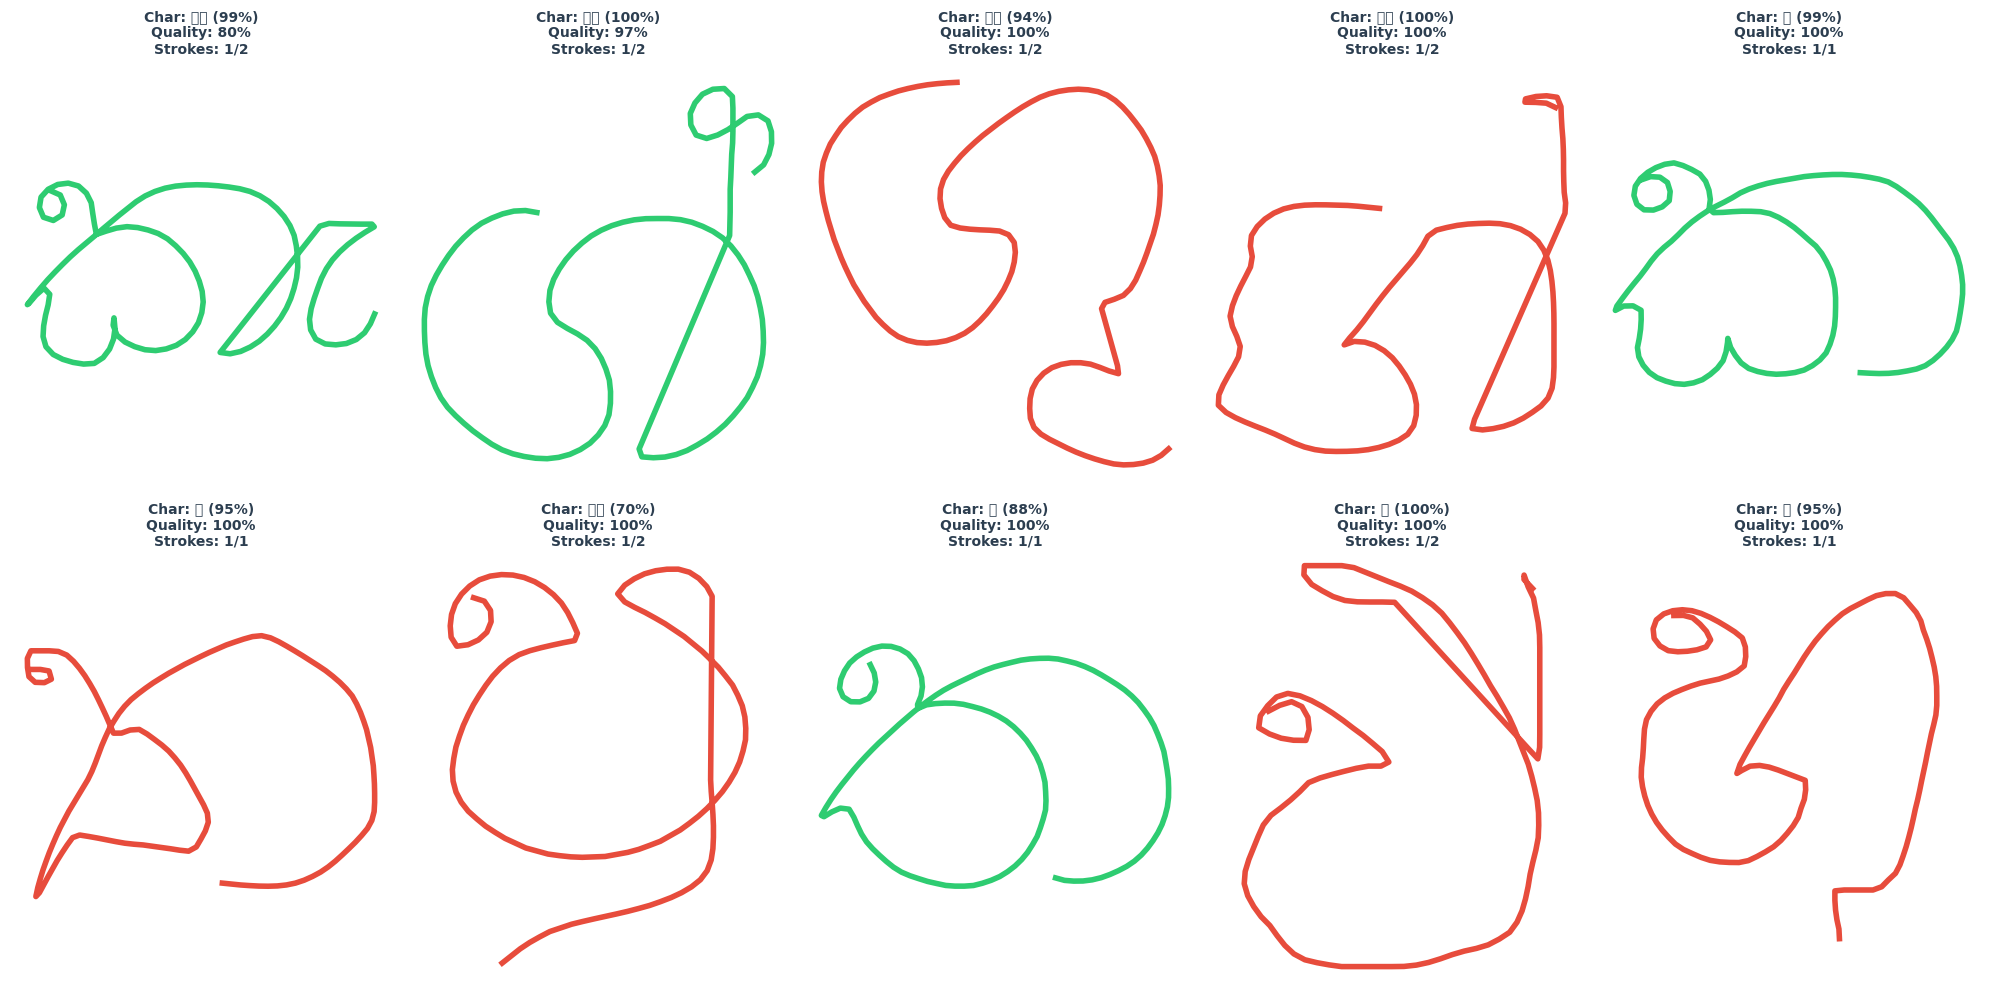

In [13]:
import random
import glob

def run_batch_test(num_samples=10):
    """
    Selects random JSON files from the dataset and displays integrated results in a grid.
    """
    # 1. පද්ධතියේ ඇති සියලුම JSON ගොනු ලැයිස්තුගත කිරීම
    all_files = glob.glob('json/correct/*.json') + glob.glob('json/wrong/*.json')
    
    if not all_files:
        print("⚠️ No JSON files found. Please ensure the dataset is extracted correctly.")
        return

    # 2. අහඹු ලෙස ගොනු 10 ක් තෝරා ගැනීම
    selected_files = random.sample(all_files, min(num_samples, len(all_files)))
    
    # 3. ප්‍රතිඵල පෙන්වීමට Grid එකක් සකස් කිරීම
    plt.figure(figsize=(20, 10))
    print(f"🚀 Batch Testing: Processing {len(selected_files)} random samples...\n")

    for i, file_path in enumerate(selected_files):
        # දත්ත පූර්ව සැකසුම (Preprocessing)
        processed_data, raw_strokes = preprocess_for_inference(file_path)
        if processed_data is None: continue

        # Model A: Character Recognition
        input_char = char_scaler.transform(processed_data.reshape(-1, 5)).reshape(1, 150, 5)
        char_pred = char_model.predict(input_char, verbose=0)
        char_idx = np.argmax(char_pred)
        eng_label = DYNAMIC_CLASSES[char_idx]
        
        # Model B: Quality Assessment
        input_qual = qual_scaler.transform(processed_data.reshape(-1, 5)).reshape(1, 150, 5)
        qual_score = qual_model.predict(input_qual, verbose=0)[0][0]
        
        # Metadata from config.json
        meta = CHAR_CONFIG.get(eng_label, {"symbol": eng_label, "strokes": 1})
        sinhala_char = meta['symbol']
        expected_strokes = meta['strokes']
        actual_strokes = len(raw_strokes)
        
        # Logic for success/fail
        is_correct_quality = qual_score >= 0.5
        result_color = "#2ecc71" if is_correct_quality else "#e74c3c"
        
        # පින්තූරය ඇඳීම
        plt.subplot(2, 5, i + 1)
        for s in raw_strokes:
            plt.plot([p['x'] for p in s], [p['y'] for p in s], linewidth=4, color=result_color)
        
        plt.gca().invert_yaxis()
        plt.axis('equal'); plt.axis('off')
        
        # විස්තර සටහන් කිරීම
        title = f"Char: {sinhala_char} ({np.max(char_pred)*100:.0f}%)\n"
        title += f"Quality: {qual_score*100 if is_correct_quality else (1-qual_score)*100:.0f}%\n"
        title += f"Strokes: {actual_strokes}/{expected_strokes}"
        
        plt.title(title, fontsize=10, fontweight='bold', color="#2c3e50")

    plt.tight_layout()
    plt.show()

# Run the Batch Test
run_batch_test(10)